In [1]:
import multiprocessing

import numpy as np
import pandas as pd

from sktime.transformations.base import BaseTransformer

__author__ = ["ChangWeiTan", "fstinner", "angus924"]


class MultiRocketMultivariate(BaseTransformer):
    """Multi RandOm Convolutional KErnel Transform (MultiRocket).

    MultiRocket [1]_ is uses the same set of kernels as MiniRocket on both the raw
    series and the first order differenced series representation. It uses a different
    set of dilations and used for each representation. In addition to percentage of
    positive values (PPV) MultiRocket adds 3 pooling operators: Mean of Positive
    Values (MPV); Mean of Indices of Positive Values (MIPV); and Longest Stretch of
    Positive Values (LSPV). This version is the multivariate version.

    This transformer fits one set of paramereters per individual series,
    and applies the transform with fitted parameter i to the i-th series in transform.
    Vanilla use requires same number of series in fit and transform.

    To fit and transform series at the same time,
    without an identification of fit/transform instances,
    wrap this transformer in ``FitInTransform``,
    from ``sktime.transformations.compose``.

    Parameters
    ----------
    num_kernels : int, default=6,250
       number of random convolutional kernels. This should be a multiple of 84.
       If it is lower than 84, it will be set to 84. If it is higher than 84
       and not a multiple of 84, the number of kernels used to transform the
       data will rounded down to the next positive multiple of 84.
    max_dilations_per_kernel : int, default=32
        maximum number of dilations per kernel.
    n_features_per_kernel : int, default =4
        number of features per kernel.
    normalise : bool, default False
    n_jobs : int, default=1
        The number of jobs to run in parallel for `transform`. ``-1`` means using all
        processors.
    random_state : None or int, default = None

    Attributes
    ----------
    parameter : tuple
        parameter (dilations, num_features_per_dilation, biases) for
        transformation of input X
    parameter1 : tuple
        parameter (dilations, num_features_per_dilation, biases) for
        transformation of input X1 = np.diff(X, 1)
    num_kernels_ : int
        The true number of kernels used in the rocket transform. This is
        num_kernels rounded down to the nearest multiple of 84. It is 84 if
        num_kernels is less than 84. The calculated number of features is given
        as 2*n_features_per_kernel*num_kernels_.

    See Also
    --------
    MultiRocketMultivariate, MiniRocket, MiniRocketMultivariate, Rocket

    References
    ----------
    .. [1] Tan, Chang Wei and Dempster, Angus and Bergmeir, Christoph and
    Webb, Geoffrey I, "MultiRocket: Multiple pooling operators and transformations
    for fast and effective time series classification",2022,
    https://link.springer.com/article/10.1007/s10618-022-00844-1
    https://arxiv.org/abs/2102.00457

    Examples
    --------
     >>> from sktime.transformations.panel.rocket import Rocket
     >>> from sktime.datasets import load_basic_motions
     >>> X_train, y_train = load_basic_motions(split="train") # doctest: +SKIP
     >>> X_test, y_test = load_basic_motions(split="test") # doctest: +SKIP
     >>> trf = MultiRocketMultivariate(num_kernels=512) # doctest: +SKIP
     >>> trf.fit(X_train) # doctest: +SKIP
     MultiRocketMultivariate(...)
     >>> X_train = trf.transform(X_train) # doctest: +SKIP
     >>> X_test = trf.transform(X_test) # doctest: +SKIP
    """

    _tags = {
        # packaging info
        # --------------
        "authors": ["ChangWeiTan", "fstinner", "angus924"],
        "maintainers": ["ChangWeiTan", "fstinner", "angus924"],
        "python_dependencies": "numba",
        # estimator type
        # --------------
        "univariate-only": False,
        "fit_is_empty": False,
        "scitype:transform-input": "Series",
        # what is the scitype of X: Series, or Panel
        "scitype:transform-output": "Primitives",
        # what is the scitype of y: None (not needed), Primitives, Series, Panel
        "scitype:instancewise": False,  # is this an instance-wise transform?
        "X_inner_mtype": "numpy3D",  # which mtypes do _fit/_predict support for X?
        "y_inner_mtype": "None",  # which mtypes do _fit/_predict support for X?
    }

    def __init__(
        self,
        num_kernels=6_250,
        max_dilations_per_kernel=32,
        n_features_per_kernel=4,
        normalise=False,
        n_jobs=1,
        random_state=None,
    ):
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.n_features_per_kernel = n_features_per_kernel
        self.num_kernels = num_kernels
        self.num_kernels_ = None
        self.normalise = normalise
        self.n_jobs = n_jobs
        self.random_state = random_state if isinstance(random_state, int) else None

        self.parameter = None
        self.parameter1 = None

        super().__init__()

    def _fit(self, X, y=None):
        """Fit dilations and biases to input time series.

        Parameters
        ----------
        X : 3D np.ndarray of shape = [n_instances, n_dimensions, series_length]
            panel of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        self
        """
        if self.normalise:
            X = (X - X.mean(axis=-1, keepdims=True)) / (
                X.std(axis=-1, keepdims=True) + 1e-8
            )

        if X.shape[2] < 10:
            # handling very short series (like PensDigit from the MTSC archive)
            # series have to be at least a length of 10 (including differencing)
            _X1 = np.zeros((X.shape[0], X.shape[1], 10), dtype=X.dtype)
            _X1[:, :, : X.shape[2]] = X
            X = _X1
            del _X1

        X = X.astype(np.float64)

        self.parameter = self._get_parameter(X)
        _X1 = np.diff(X, 1)

        self.parameter1 = self._get_parameter(_X1)

        if self.num_kernels < 84:
            self.num_kernels_ = 84
        else:
            self.num_kernels_ = (self.num_kernels // 84) * 84

        return self

    def _transform(self, X, y=None):
        """Transform input time series using random convolutional kernels.

        Parameters
        ----------
        X : 3D np.ndarray of shape = [n_instances, n_dimensions, series_length]
            panel of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        pandas DataFrame, transformed features
        """
        from numba import get_num_threads, set_num_threads

        from sktime.transformations.panel.rocket._multirocket_multi_numba import (
            _transform,
        )

        if self.normalise:
            X = (X - X.mean(axis=-1, keepdims=True)) / (
                X.std(axis=-1, keepdims=True) + 1e-8
            )

        _X1 = np.diff(X, 1)

        # change n_jobs depended on value and existing cores
        prev_threads = get_num_threads()
        if self.n_jobs < 1 or self.n_jobs > multiprocessing.cpu_count():
            n_jobs = multiprocessing.cpu_count()
        else:
            n_jobs = self.n_jobs
        set_num_threads(n_jobs)

        X = _transform(
            X,
            _X1,
            self.parameter,
            self.parameter1,
            self.n_features_per_kernel,
        )
        X = np.nan_to_num(X)

        set_num_threads(prev_threads)

        return pd.DataFrame(X)

    def _get_parameter(self, X):
        from sktime.transformations.panel.rocket._multirocket_multi_numba import (
            _fit_biases,
            _fit_dilations,
            _quantiles,
        )

        if self.random_state is not None:
            np.random.seed(self.random_state)

        _, num_channels, input_length = X.shape

        num_kernels = 84

        dilations, num_features_per_dilation = _fit_dilations(
            input_length, self.num_kernels, self.max_dilations_per_kernel
        )

        num_features_per_kernel = np.sum(num_features_per_dilation)

        quantiles = _quantiles(num_kernels * num_features_per_kernel)

        num_dilations = len(dilations)
        num_combinations = num_kernels * num_dilations

        max_num_channels = min(num_channels, 9)
        max_exponent = np.log2(max_num_channels + 1)

        num_channels_per_combination = (
            2 ** np.random.uniform(0, max_exponent, num_combinations)
        ).astype(np.int32)

        channel_indices = np.zeros(num_channels_per_combination.sum(), dtype=np.int32)

        num_channels_start = 0
        for combination_index in range(num_combinations):
            num_channels_this_combination = num_channels_per_combination[
                combination_index
            ]
            num_channels_end = num_channels_start + num_channels_this_combination
            channel_indices[num_channels_start:num_channels_end] = np.random.choice(
                num_channels, num_channels_this_combination, replace=False
            )

            num_channels_start = num_channels_end

        biases = _fit_biases(
            X,
            num_channels_per_combination,
            channel_indices,
            dilations,
            num_features_per_dilation,
            quantiles,
            self.random_state,
        )

        return (
            num_channels_per_combination,
            channel_indices,
            dilations,
            num_features_per_dilation,
            biases,
        )

    @classmethod
    def get_test_params(cls):
        """Return testing parameter sets for the estimator."""
        return [
            {
                "num_kernels": 10,
                "max_dilations_per_kernel": 32,
                "random_state": 42,
            },  # First parameter set
            {
                "num_kernels": 20,
                "max_dilations_per_kernel": 16,
                "random_state": 0,
            },  # Second parameter set
        ]

In [2]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=240):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=240, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/10KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (23682, 66, 13)
Labels array shape: (23682,)


In [4]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [5]:
print(X.shape)

(23682, 13, 66)


In [6]:
print(X_train.shape)

(18945, 13, 66)


In [7]:
trf = MultiRocketMultivariate(num_kernels=9996)


In [8]:
# Fit the transformer on the training data
trf.fit(X_train)


MultiRocketMultivariate(num_kernels=9996)

In [9]:
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

# Now apply transformation
X_train_transformed = trf.transform(X_train)
X_test_transformed = trf.transform(X_test)


In [10]:
from sklearn.linear_model import RidgeClassifierCV
# Initialize the RidgeClassifierCV with cross-validation for alpha selection
ridge_clf_cv = RidgeClassifierCV(
    alphas=np.logspace(-3, 3, 10),  # Regularization parameter to search over
   
)

In [11]:
# Fit the classifier on the transformed training data
ridge_clf_cv.fit(X_train_transformed, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [12]:
# Predict on the test data
y_pred = ridge_clf_cv.predict(X_test_transformed)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8154950390542538


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.8166127796314093
Recall (macro): 0.8153382783479539
F1 Score (macro): 0.8156949626267853


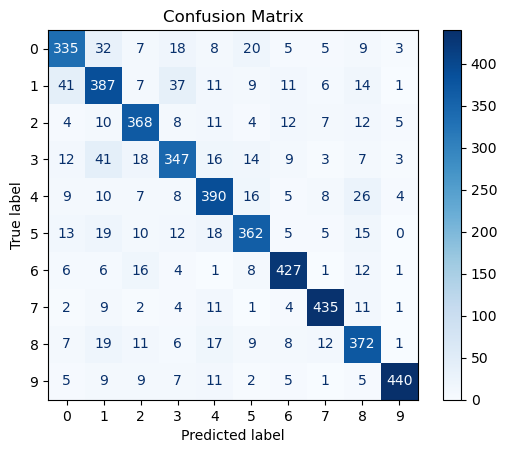

In [15]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




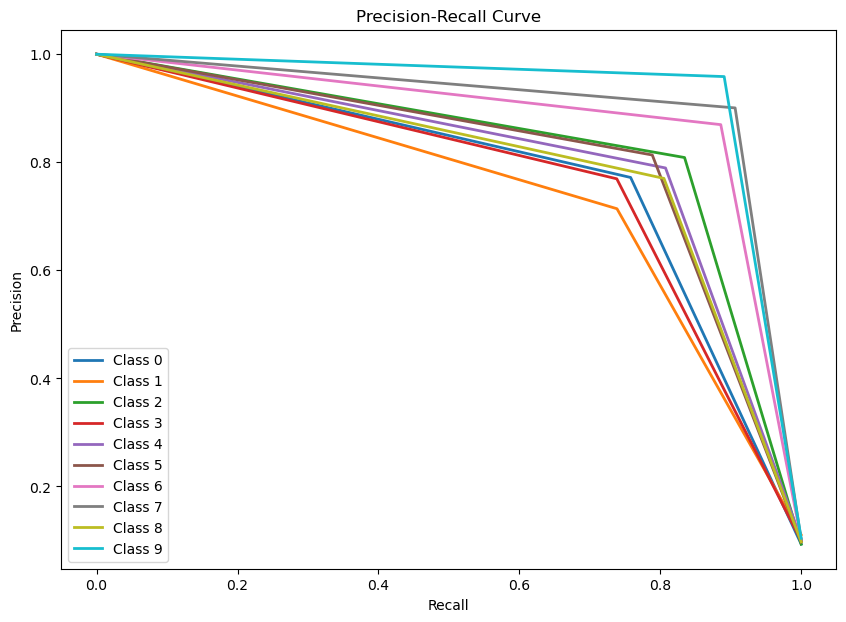

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [17]:
print(X_train_transformed.shape)

(18945, 79968)


In [18]:
print(X_test_transformed.shape)

(4737, 79968)


In [19]:
# Get predicted probabilities using the predict_proba() method
y_pred_prob = clf.predict_proba(X_test)

# Binarize the true labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

n_classes = 10

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get precision and recall for each class using the predicted probabilities
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


NameError: name 'clf' is not defined